# CM3070 Final Project, Local Modelling

```
University of London
BSc Computer Science
CM3070, Final Project
Hudson Leonardo MENDES
hlm12@student.london.ac.uk
```

## Introduction

The present notebook is used to run the mock training process in a Jupyter Notebook<br />
environment, to increase odds of having a version that will train appropriately<br />
in this project's MLOps Infrastructure (in Google Colab).

## Environment

### Dependencies

In [1]:
!cat ../pyproject.toml

[build-system]
requires = ["setuptools", "wheel"]

[project]
name = "hlm12erc"
version = "0.0.1"
authors = [{ name = "Hudson Mendes", email = "hlm12@student.london.ac.uk" }]
description = "Final Project from University of London"
readme = "README.md"
license = { file = "LICENSE" }
urls = { homepage = "https://github.com/hudsonmendes/cm3070-fp" }
keywords = ["university-of-london"]
dependencies = [
    "torch >= 2.0.1",
    "torchtext >= 0.15.2",
    "torchvision >= 0.15.2",
    "transformers >= 4.30.2",
    "Pillow >= 10.0.0",
    "scikit-learn >= 1.3.0",
]

[project.optional-dependencies]
dev = ["pre-commit>=3.3.3", "black[jupyter]>=23.7.0", "isort>=5.12.0"]
test = ["pytest>=7.4.0"]
etl = [
    "kaggle>=1.5.13",
    "tqdm>=4.65.0",
    "pandas>=2.0.1",
    "google-cloud-storage>=2.10.0",
    "moviepy>=1.0.3",
]
eda = [
    "gensim",
    "tensorflow",
    "tensorflow-hub",
    "torch",
    "transformers",
    "librosa",
    "umap-learn",
    "matplotlib",
    "wordcloud",
    "pyLDAvis

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging

logging.basicConfig(level=logging.INFO)

### Paths & Locations

In [4]:
import os

# set the working directory to the parent folder, where
# all the code, cache, data, etc. folders are located
if os.getcwd().split("/")[-1] == "dev":
    os.chdir("../")
os.getcwd()

'/Users/hudsonmendes/Workspaces/universityoflondon/cm3070-fp'

In [5]:
import pathlib

# now that the chdir is set to the parent directory of the notebook,
# we can work as if we were running in the root directory of the repository
dir_home = pathlib.Path("./")
dir_data = dir_home / "data"
dir_target = dir_home / "target"
dir_configs = dir_home / "configs"

## Assembling the DataSet


### Installing ETL Dependencies



In [6]:
%%capture
%pip install -e '..[etl]'

### Running ETL

In [7]:
from hlm12erc.etl import ETL, KaggleDataset

ds_kaggle = KaggleDataset(owner="zaber666", name="meld-dataset", subdir="MELD-RAW/MELD.Raw")
etl = ETL(dataset=ds_kaggle).into(uri_or_folderpath=dir_data)

INFO:hlm12erc.etl:Kaggle dataset: zaber666/meld-dataset
INFO:hlm12erc.etl:Workspace set to: /tmp/hlm12erc/etl
INFO:hlm12erc.etl:Dataset already loaded into data, skipping (use force=True to force re-load).


### Previewing Data Loaded

In [8]:
!ls {str(dir_data)} | head -n 10

d-0-seq-0.png
d-0-seq-0.wav
d-0-seq-1.png
d-0-seq-1.wav
d-0-seq-10.png
d-0-seq-10.wav
d-0-seq-11.png
d-0-seq-11.wav
d-0-seq-12.png
d-0-seq-12.wav


In [9]:
import pandas as pd

df_raw = pd.read_csv(dir_data / "train.csv", index_col=0)
df_raw

,dialogue,sequence,speaker,x_text,x_visual,x_audio,label
0,0,0,Chandler,also I was the point person on my companys tr...,d-0-seq-0.png,d-0-seq-0.wav,neutral
1,0,1,The Interviewer,You mustve had your hands full.,d-0-seq-1.png,d-0-seq-1.wav,neutral
2,0,2,Chandler,That I did. That I did.,d-0-seq-2.png,d-0-seq-2.wav,neutral
3,0,3,The Interviewer,So lets talk a little bit about your duties.,d-0-seq-3.png,d-0-seq-3.wav,neutral
4,0,4,Chandler,My duties? All right.,d-0-seq-4.png,d-0-seq-4.wav,surprise
...,...,...,...,...,...,...,...
9984,1038,13,Chandler,You or me?,d-1038-seq-13.png,d-1038-seq-13.wav,neutral
9985,1038,14,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",d-1038-seq-14.png,d-1038-seq-14.wav,neutral
9986,1038,15,Joey,"You guys are messing with me, right?",d-1038-seq-15.png,d-1038-seq-15.wav,surprise
9987,1038,16,All,Yeah.,d-1038-seq-16.png,d-1038-seq-16.wav,neutral


Speaker,Text,Image,Audio,Emotion
Peter,Were not throwing it away! I built that canoe!,,,anger
Liam,"Ross, come on! Get in the bloody scrum! Ross, get in!",,,anger
Rachel,"Yknow what? No. Its not over until someone says, ""I do.""",,,anger
Rachel,"Pheebs, this guy has been obsessed with your sister, for God knows how long, okay, you don't just give up something like that.",,,disgust
Phoebe,"That's fine, just don't bring it in my mouth.",,,disgust
Rachel,Have you ever seen so much crap?,,,disgust
Monica,Not yet! Not yet! Not yet! Not yet! Not yet! Not yet! Not yet! Not yet!,,,fear
Chandler,"Look I never should have kissed your girlfriend, but Im",,,fear
Joey,Take a couple deep breaths.,,,fear
Rachel,"This-this, no, oh no, no-no-no, this is notthats-thats not what it is.",,,joy

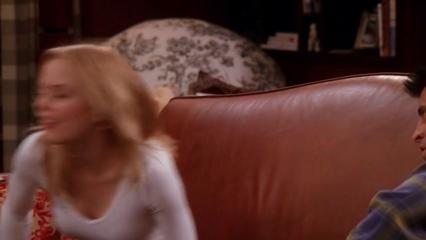
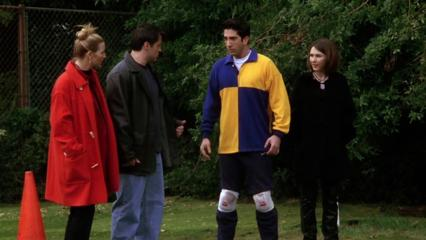
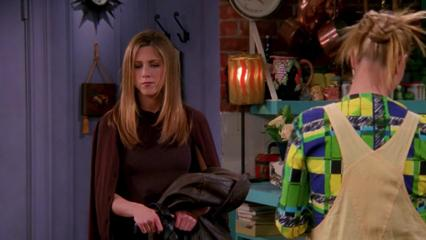
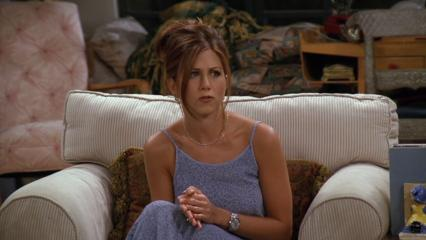
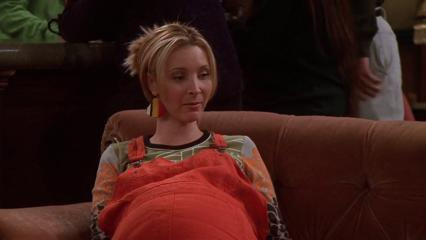
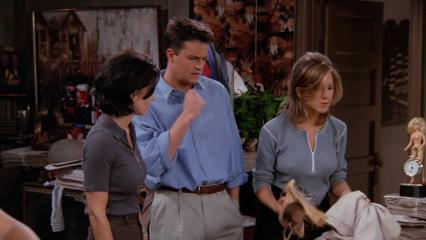
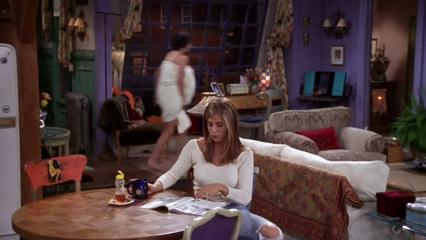
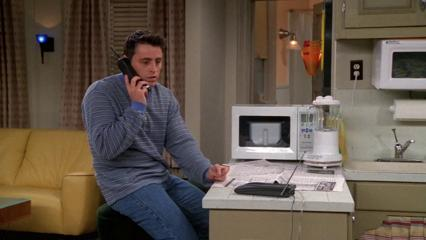
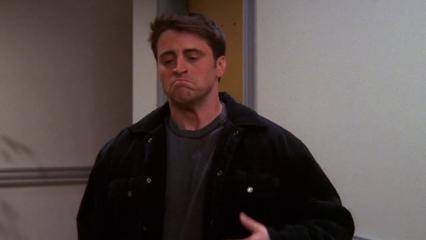
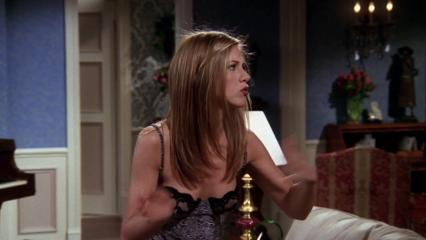
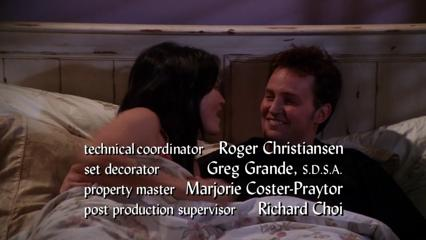
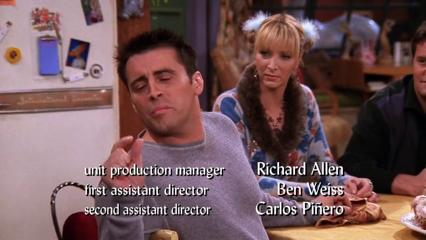
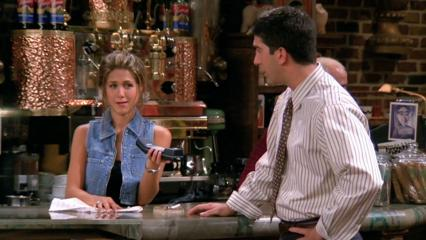
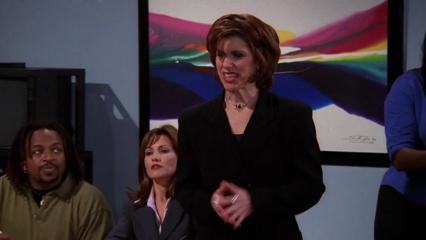
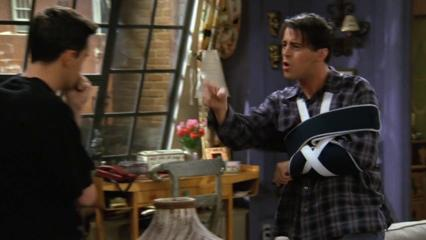
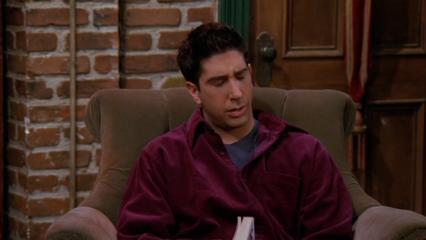
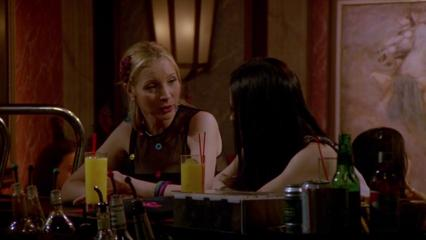
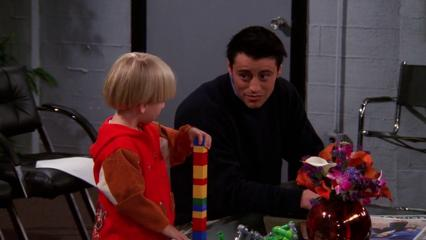
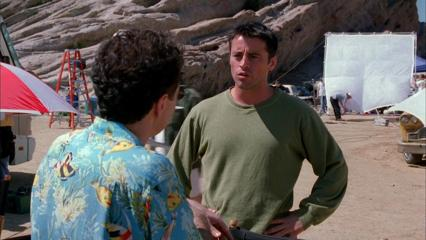
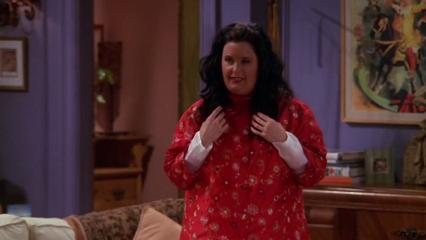
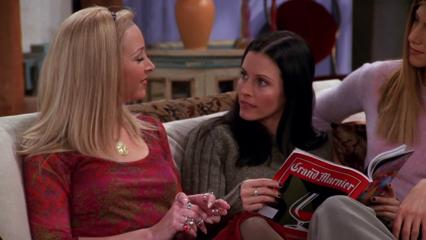

In [10]:
import io
import base64
from IPython.display import display, HTML
from PIL import Image

df_sample = df_raw.groupby(["label"], group_keys=False).apply(lambda x: x.sample(min(len(x), 3)))
df_sample = df_sample.sort_values(["label"])

table_rows = []
for i, row in df_sample.iterrows():
    speaker_cell = f'<td>{row["speaker"]}</td>'
    text_cell = f'<td>{row["x_text"]}</td>'
    image_path = dir_data / row["x_visual"]
    with Image.open(image_path) as img:
        width, height = img.size
        crop_top = height // 2 - height // 10
        crop_bottom = height // 2 + height // 10
        img_cropped = img.crop((0, crop_top, width, crop_bottom))
        buffer = io.BytesIO()
        img_cropped.save(buffer, format="JPEG")
        image_data = base64.b64encode(buffer.getvalue()).decode()
    image_cell = f'<td><img src="data:image/jpeg;base64,{image_data}" width="100"></td>'
    audio_cell = f'<td><audio controls src="{os.path.join("../data/", row["x_audio"])}" /></td>'
    label_cell = f'<td>{row["label"]}</td>'
    table_rows.append(f"<tr>{speaker_cell}{text_cell}{image_cell}{audio_cell}{label_cell}</tr>")

table_html = (
    "<table><tr><th>Speaker</th><th>Text</th><th>Image</th><th>Audio</th><th>Emotion</th></tr>"
    + "".join(table_rows)
    + "</table>"
)
display(HTML(table_html))

## Data Preparation

In [11]:
%%capture
%pip install -e '..[training]'

## 8. Mock Training


In [12]:
%env WANDB_NOTEBOOK_NAME=dev/local.ipynb
%env WANDB_PROJECT=hlm12erc

env: WANDB_NOTEBOOK_NAME=dev/local.ipynb
env: WANDB_PROJECT=hlm12erc


In [13]:
import warnings

warnings.filterwarnings("ignore")

In [14]:
from hlm12erc.training import MeldDataset

ds_sample = MeldDataset(dir_data / f"sample.csv")

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/gt/j16393sd52s3xsm_3fsd_3qr0000gn/T/tmpuetc0skk
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/gt/j16393sd52s3xsm_3fsd_3qr0000gn/T/tmpuetc0skk/_remote_module_non_scriptable.py


In [15]:
from hlm12erc.modelling import ERCConfigLoader
from hlm12erc.training import ERCTrainer

model_config = ERCConfigLoader(dir_configs / f"mock.yml").load()
model_trainer = ERCTrainer(model_config)
model_name, model_instance = model_trainer.train((ds_sample, ds_sample), batch_size=4, n_epochs=1, save_to=(dir_target))
model_name

INFO:hlm12erc.training.erc_trainer:Training the model...
INFO:hlm12erc.training.erc_trainer:Training & Validation datasets unpacked
INFO:hlm12erc.training.erc_trainer:Training with config passed to trainer
INFO:hlm12erc.training.erc_trainer:Label Encoder loaded with classes: fear, neutral, sadness, surprise
INFO:hlm12erc.training.erc_trainer:Model identifier hlm12erc-mock-glove-resnet50-waveform-concat-t50x50-a150000x32-ffl512+32-cce
INFO:torchtext.vocab.vectors:Loading vectors from .vector_cache/glove.6B.50d.txt.pt
Using cache found in /Users/hudsonmendes/.cache/torch/hub/pytorch_vision_v0.6.0
INFO:hlm12erc.training.erc_trainer:Model created in device cpu
INFO:hlm12erc.training.erc_trainer:Training workspace set to: target/hlm12erc-mock-glove-resnet50-waveform-concat-t50x50-a150000x32-ffl512+32-cce
INFO:hlm12erc.training.erc_trainer:TrainingArgs created with 1 epochs and batch size 4
INFO:hlm12erc.training.erc_trainer:Trainer, train=21, valid=21, device=cpu
INFO:hlm12erc.training.erc_

  0%|          | 0/6 [00:11<?, ?it/s]

{'loss': 1.49405038356781, 'acc': 0.25, 'f1_weighted': 0.4, 'epoch': 0}


 17%|█▋        | 1/6 [00:20<01:30, 18.00s/it]

{'loss': 1.4951167106628418, 'acc': 0.25, 'f1_weighted': 0.4, 'epoch': 0.17}


 33%|███▎      | 2/6 [00:29<00:50, 12.72s/it]

{'loss': 1.5097284317016602, 'acc': 0.0, 'f1_weighted': 0.0, 'epoch': 0.33}


 50%|█████     | 3/6 [00:38<00:31, 10.66s/it]

{'loss': 1.509814739227295, 'acc': 0.0, 'f1_weighted': 0.0, 'epoch': 0.5}


 67%|██████▋   | 4/6 [00:46<00:19,  9.54s/it]

{'loss': 1.5191130638122559, 'acc': 0.0, 'f1_weighted': 0.0, 'epoch': 0.67}


 83%|████████▎ | 5/6 [00:51<00:09,  9.02s/it]

{'loss': 1.5194807052612305, 'acc': 0.0, 'f1_weighted': 0.0, 'epoch': 0.83}


100%|██████████| 6/6 [00:55<00:00,  6.61s/it]

{'loss': 1.5189684629440308, 'acc': 0.0, 'f1_weighted': 0.0, 'epoch': 1.0}


                                             
100%|██████████| 6/6 [01:00<00:00,  6.61s/it]

{'loss': 1.5095510482788086, 'acc': 0.0, 'f1_weighted': 0.0, 'epoch': 1.0}


                                             
100%|██████████| 6/6 [01:03<00:00,  6.61s/it]

{'loss': 1.5044670104980469, 'acc': 0.25, 'f1_weighted': 0.4, 'epoch': 1.0}


                                             
100%|██████████| 6/6 [01:06<00:00,  6.61s/it]

{'loss': 1.49894380569458, 'acc': 0.0, 'f1_weighted': 0.0, 'epoch': 1.0}


                                             
100%|██████████| 6/6 [01:09<00:00,  6.61s/it]

{'loss': 1.4950635433197021, 'acc': 0.25, 'f1_weighted': 0.4, 'epoch': 1.0}


                                             
                                             
100%|██████████| 6/6 [01:10<00:00,  6.61s/it]

{'loss': 1.5189318656921387, 'acc': 0.0, 'f1_weighted': 0.0, 'epoch': 1.0}
{'eval_loss': 1.3989542722702026, 'eval_acc': 0.09523809523809523, 'eval_f1_weighted': 0.016563146997929604, 'eval_runtime': 16.9399, 'eval_samples_per_second': 1.24, 'eval_steps_per_second': 0.354, 'epoch': 1.0}


100%|██████████| 6/6 [01:13<00:00, 12.26s/it]
INFO:hlm12erc.training.erc_trainer:Training complete, saving model...


{'train_runtime': 78.8287, 'train_samples_per_second': 0.266, 'train_steps_per_second': 0.076, 'train_loss': 1.4007960955301921, 'epoch': 1.0}


INFO:hlm12erc.training.erc_trainer:Model saved into disk target/hlm12erc-mock-glove-resnet50-waveform-concat-t50x50-a150000x32-ffl512+32-cce/model.pt
INFO:hlm12erc.training.erc_trainer:Uploading Metrics & Artifacts to W&B, ...


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/acc,▁
eval/f1_weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/acc,██▁▁▁▁▁▁█▁█▁
train/epoch,▁▂▃▅▆▇████████
train/f1_weighted,██▁▁▁▁▁▁█▁█▁
train/global_step,▁▂▃▅▆▇████████
train/loss,▁▁▅▅███▅▄▂▁█


INFO:hlm12erc.training.erc_trainer:W&B run marked as completed.


'hlm12erc-mock-glove-resnet50-waveform-concat-t50x50-a150000x32-ffl512+32-cce'

In [16]:
from hlm12erc.training import ERCEvaluator

model_evaluator = ERCEvaluator(model_instance)
model_eval_results = model_evaluator.evaluate(ds_sample, batch_size=4)
model_eval_results

evaluating: 100%|██████████| 6/6 [00:36<00:00,  6.03s/it]


              precision    recall  f1-score   support

        fear       0.10      1.00      0.17         2
     neutral       0.00      0.00      0.00        14
     sadness       0.00      0.00      0.00         1
    surprise       0.00      0.00      0.00         4

    accuracy                           0.10        21
   macro avg       0.02      0.25      0.04        21
weighted avg       0.01      0.10      0.02        21



{'fear': {'precision': 0.09523809523809523,
  'recall': 1.0,
  'f1-score': 0.17391304347826084,
  'support': 2.0},
 'neutral': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 14.0},
 'sadness': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0},
 'surprise': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 4.0},
 'accuracy': 0.09523809523809523,
 'macro avg': {'precision': 0.023809523809523808,
  'recall': 0.25,
  'f1-score': 0.04347826086956521,
  'support': 21.0},
 'weighted avg': {'precision': 0.009070294784580499,
  'recall': 0.09523809523809523,
  'f1-score': 0.016563146997929604,
  'support': 21.0}}